In [1]:
import xarray as xr
import shapely
import numpy as np
import os.path
import cartopy.io.shapereader as shpreader

data_path = 'C:\\Users\\duncan\\Downloads\\'

In [21]:
#Load the shapefile
shapefile = 'UK_covid_reporting_regions.shx'
regions_reader = shpreader.Reader(os.path.join(data_path, shapefile))

In [22]:
#Helper function to get the record from the reader
def get_region_record(target, shapefile=regions_reader, attribute='OBJECTID'):
    '''
    Get the geometries for the specified target.
    
    '''
    result = None
    for record in shapefile.records():
        location = record.attributes[attribute]
        if location == target:
            result = record
            break
    if result is None:
        emsg = f'Could not find region with {attribute} "{target}".'
        raise ValueError(emsg)
    return result



In [155]:
def roll_da(da):
    rolled = da.roll(longitude=da.dims['longitude'] // 2, roll_coords=False)
    rolled = rolled.assign_coords(longitude=da.longitude - 180.)
    return rolled

def get_indices_for_lat_lon_points(lats, lons, region):
    from shapely.geometry import MultiPoint

    lat_lon_points = np.vstack([lats, lons])
    points = MultiPoint(lat_lon_points.T)

    # Performance in this loop might be an issue, but I think it's essentially how GeoPandas does it. If I want to
    #  improve it I might need to look at using something like rtree.
    return [i for i, p in enumerate(points) if region.contains(p)]

def get_gridded_subset_region_indices(ds, region):
    """
    Get a set of indices representing the lat/lon points within a given region
    """    
    x, y = np.meshgrid(ds.longitude, ds.latitude)
    return get_indices_for_lat_lon_points(x.flat, y.flat, region)

def extract_region(ds, region):
    """
    Return a dataset representing the data which falls within a given region, flattened along a new dimension
    """
    
    # Ensure the longitudes match the shapefiles
    if any(ds.longitude>180):
        temp_ds = roll_da(ds)
    else:
        temp_ds = ds
    
    # Do a fast, coarse subset first
    xmin, ymin, xmax, ymax = region.bounds
    temp_ds = temp_ds.sel(longitude=slice(xmin, xmax), latitude=slice(ymin, ymax))

    matched_indices = get_gridded_subset_region_indices(temp_ds, region)
    
    # Do point-wise indexing (along a new dimension)
    # TODO - this is a bit fragile as it depends on the order of the longitude and latitude dimensions
    x, y = np.unravel_index(indxs, (temp_ds.latitude.shape[0], temp_ds.longitude.shape[0]))
    return temp_ds.isel(latitude=xr.DataArray(x, dims="obs "), longitude=xr.DataArray(y, dims="obs "))

# Example usage

In [156]:
# Read a global dataset
rh = xr.open_dataset(os.path.join(data_path, 'rh1o5m_global_20200324.nc'))
rh

<xarray.Dataset>
Dimensions:                  (forecast_period: 6, forecast_reference_time: 4, latitude: 1920, longitude: 2560)
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 00:00:00 ... 05:00:00
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 2020-03-24 ... 2020-03-24T18:00:00
  * latitude                 (latitude) float32 -89.953125 ... 89.953125
  * longitude                (longitude) float32 0.0703125 ... 359.9297
    height                   float64 ...
    time                     (forecast_reference_time, forecast_period) datetime64[ns] ...
Data variables:
    relative_humidity        (forecast_period, forecast_reference_time, latitude, longitude) float32 ...
    latitude_longitude       int32 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   11.2
    Conventions:  CF-1.5

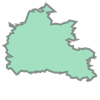

In [157]:
#Get an example geometry
oxfordshire = get_region_record("Oxfordshire", regions_reader, 'name').geometry
oxfordshire

In [159]:
oxfordshire_rh = extract_region(rh, oxfordshire)

(array([ 9., 75., 85., 47., 51., 62., 80., 93., 60., 38.]),
 array([46.375, 50.825, 55.275, 59.725, 64.175, 68.625, 73.075, 77.525,
        81.975, 86.425, 90.875], dtype=float32),
 <a list of 10 Patch objects>)

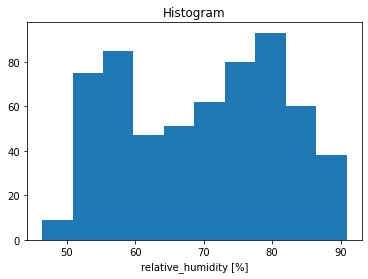

In [162]:
oxfordshire_rh["relative_humidity"].plot()